## Setup

In [1]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# Connecting EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

## Loading the Data

In [2]:
import boto3

cn_regions = ['cn-north-1', 'cn-northwest-1']
region = boto3.Session().region_name
endpoint_domain = 'com.cn' if region in cn_regions else 'com'
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.{}'.format(region, endpoint_domain))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



## Training with K-Means and Hosting a Model

In [3]:
from sagemaker_pyspark import IAMRole
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory

# Create K-Means Estimator
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType = 'ml.m4.xlarge', # Instance type to train K-means on SageMaker
    trainingInstanceCount = 1,
    endpointInstanceType = 'ml.t2.large', # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount = 1,
    namePolicyFactory = RandomNamePolicyFactory("sparksm-1a-")) # All the resources created are prefixed with sparksm-1

# Set parameters for K-Means - K = 10
kmeans_estimator.setFeatureDim(784)
kmeans_estimator.setK(10)

# Train
initialModel = kmeans_estimator.fit(trainingData)

# saving the name of the sagemaker endpoint hosting the model
initialModelEndpointName = initialModel.endpointName
print(initialModelEndpointName)

sparksm-1a-endpoint-244e7d6e85c1-2021-03-24T00-34-51-175


## Inference

In [4]:
# Run inference on the test data and show some results
transformedData = initialModel.transform(testData)
transformedData.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1292.4219970703125|            9.0|
|  2.0|(784,[94,95,96,97...|  2049.699951171875|            6.0|
|  1.0|(784,[128,129,130...|  896.1719360351562|            3.0|
|  0.0|(784,[124,125,126...| 1612.6651611328125|            7.0|
|  4.0|(784,[150,151,159...| 1432.4686279296875|            2.0|
|  1.0|(784,[156,157,158...|  907.3824462890625|            3.0|
|  4.0|(784,[149,150,151...|  1694.579345703125|            9.0|
|  9.0|(784,[179,180,181...|   1617.35986328125|            0.0|
|  5.0|(784,[129,130,131...|   1996.02099609375|            2.0|
|  9.0|(784,[209,210,211...| 1526.4578857421875|            9.0|
|  0.0|(784,[123,124,125...| 1582.8565673828125|            7.0|
|  6.0|(784,[94,95,96,97...| 1926.2918701171875|            2.0|
|  9.0|(784,[208,209,210.

## Visualizing K-Means Performance




Cluster A:


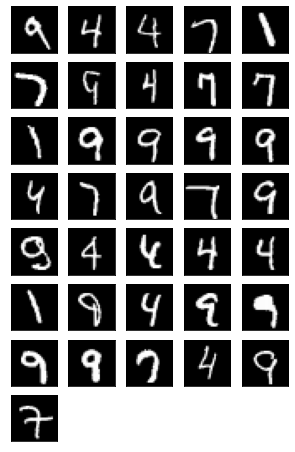




Cluster B:


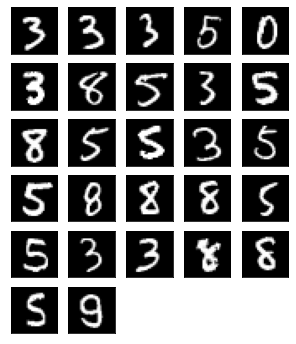




Cluster C:


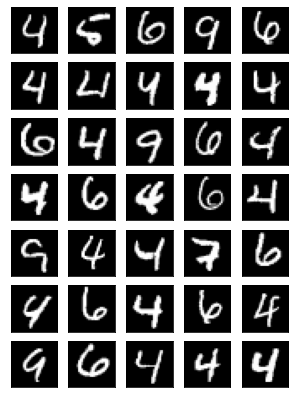




Cluster D:


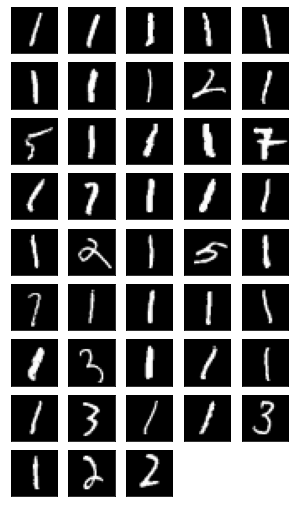




Cluster E:


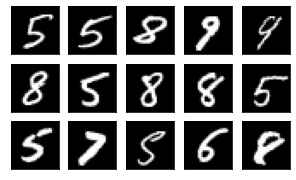




Cluster F:


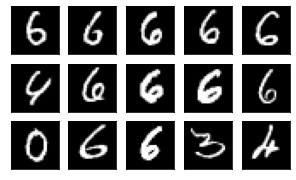




Cluster G:


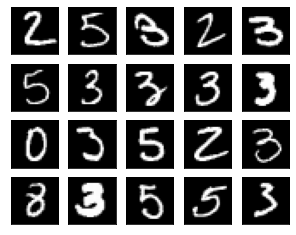




Cluster H:


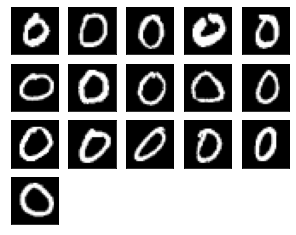




Cluster I:


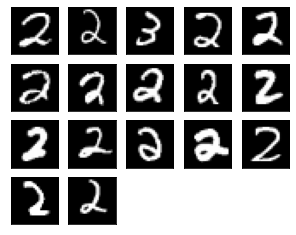




Cluster J:


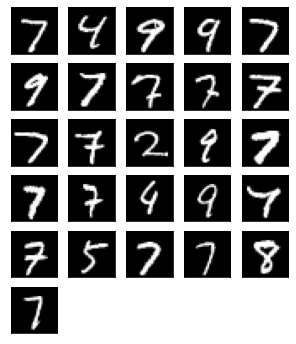

In [5]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayClusters(transformedData)

## Re-using Existing Endpoints / Models

In [6]:
from sagemaker_pyspark import SageMakerModel
from sagemaker_pyspark import EndpointCreationPolicy
from sagemaker_pyspark.transformation.serializers import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.deserializers import KMeansProtobufResponseRowDeserializer

ENDPOINT_NAME = initialModelEndpointName # getting the saved model's endpoint
attachedModel = SageMakerModel(
    existingEndpointName = ENDPOINT_NAME,
    endpointCreationPolicy = EndpointCreationPolicy.DO_NOT_CREATE, # DO_NOT_CREATE to ensure no new endpoint created
    endpointInstanceType = None, # Required
    endpointInitialInstanceCount = None, # Required
    requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "features"), # Optional: already default value
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer( # Optional: already default values
      distance_to_cluster_column_name = "distance_to_cluster",
      closest_cluster_column_name = "closest_cluster")
)

transformedData2 = attachedModel.transform(testData)
transformedData2.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1292.4219970703125|            9.0|
|  2.0|(784,[94,95,96,97...|  2049.699951171875|            6.0|
|  1.0|(784,[128,129,130...|  896.1719360351562|            3.0|
|  0.0|(784,[124,125,126...| 1612.6651611328125|            7.0|
|  4.0|(784,[150,151,159...| 1432.4686279296875|            2.0|
|  1.0|(784,[156,157,158...|  907.3824462890625|            3.0|
|  4.0|(784,[149,150,151...|  1694.579345703125|            9.0|
|  9.0|(784,[179,180,181...|   1617.35986328125|            0.0|
|  5.0|(784,[129,130,131...|   1996.02099609375|            2.0|
|  9.0|(784,[209,210,211...| 1526.4578857421875|            9.0|
|  0.0|(784,[123,124,125...| 1582.8565673828125|            7.0|
|  6.0|(784,[94,95,96,97...| 1926.2918701171875|            2.0|
|  9.0|(784,[208,209,210.

## Create Model and Endpoint from Model Data on S3

In [7]:
from sagemaker_pyspark import S3DataPath
from sagemaker_pyspark import RandomNamePolicy

MODEL_S3_PATH = S3DataPath(initialModel.modelPath.bucket, initialModel.modelPath.objectPath)
MODEL_ROLE_ARN = initialModel.modelExecutionRoleARN
MODEL_IMAGE_PATH = initialModel.modelImage

print(MODEL_S3_PATH.bucket + MODEL_S3_PATH.objectPath)
print(MODEL_ROLE_ARN)
print(MODEL_IMAGE_PATH)

retrievedModel = SageMakerModel(
    modelPath = MODEL_S3_PATH,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.t2.medium",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(), 
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-1b-"), 
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

transformedData3 = retrievedModel.transform(testData)
transformedData3.show()

966876101248-sagemaker-us-east-1cbffa76a-6df2-4342-b93a-2dd5e83080a8/sparksm-1a-trainingJob-244e7d6e85c1-2021-03-24T00-34-51-175/sparksm-1a-trainingJob-244e7d6e85c1-2021-03-24T00-34-51-175/output/model.tar.gz
arn:aws:iam::966876101248:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1
+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1292.4219970703125|            9.0|
|  2.0|(784,[94,95,96,97...|  2049.699951171875|            6.0|
|  1.0|(784,[128,129,130...|  896.1719360351562|            3.0|
|  0.0|(784,[124,125,126...| 1612.6651611328125|            7.0|
|  4.0|(784,[150,151,159...| 1432.4686279296875|            2.0|
|  1.0|(784,[156,157,158...|  907.3824462890625|            3.0|
|  4.0|(784,[149,150,151...|  1694.579345703125|            9.0

## Clean-up

In [8]:
# Delete the resources
from sagemaker_pyspark import SageMakerResourceCleanup

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())

# Don't forget to include any models or pipeline models that you created in the notebook
models = [initialModel, retrievedModel] # attachedModel == initialModel so no need to re-delete

# Delete regular SageMakerModels
for m in models:
    cleanUp(m)